# Sleep Analyze Jupyter Notebook の使い方
## はじめに
- このノートブックでは、Google Fitのデータを元に睡眠データを分析します
- [Google Fitからデータをダウンロード](https://takeout.google.com/)してください
  - Google Fitからデータをダウンロードする方法が分からない方は以下のセル(Google Fitからデータをダウンロードする方法)をご覧ください。
- このノートブックは、筆者のような**複数のデバイスを使って**睡眠記録をつけている方でも問題なく分析が行えます
- セルは一括で実行せず、1つずつ実行してください

## データ分析の流れ
1. モジュールのインポート
2. データの取り込み
3. (手動の睡眠記録がある場合)データセットの選択
4. アクトグラムを用いた四半期ごとの睡眠記録の可視化
5. 任意の日付の睡眠記録の可視化



# 更新履歴
- 睡眠時間の追加
- 睡眠潜時の追加(課題あり)


## Google Fit からデータをダウンロードする方法<a id='How2takeout'></a>


1. [Google データ エクスポート](https://takeout.google.com/)にアクセスします。
2. `追加するデータの選択` にて`選択をすべて解除`します(余計なデータが多すぎるため)。

    <img src="takeout_google_1_deselect_All.png" width="320px" alt="Access Google data export and deselect All">
    
3. `Fit`(Google Fit)のみを選択します。
    
    <img src="takeout_google_2_Select_Fit.png" width="320px" alt="Select Google Fit">
    
4. 一番下までスクロールし、`次のステップ`をクリックします。
5. ファイル形式、エクスポート回数、エクスポート先の選択をします。
   - `エクスポート先` は `ダウンロードリンクをメールで送信`を選択します
   - `頻度`は`1回エクスポート`を選択します
   - `ファイル形式`は`.zip`を選択します
   - `ファイルサイズ`は`50GB`を選択します(念の為)
   - 上記を確認した後、`エクスポートを作成`をクリックします
    
    <img src="takeout_google_3_export.png" width="320px" alt="Select Google Fit">
    
6. データのエクスポートが処理され、ダウンロードリンクがメールで送られていくるまで数時間から数日かかります。気長に待ちます(ページを閉じても大丈夫です)。
   - 進捗は[Google データ エクスポート](https://takeout.google.com/)にて確認できます
   - メールはデータのエクスポートをリクエストしたGoogleアカウント宛(gmail)に届きます
7. ダウンロードリンクが書かれたメールを開き、ダウンロードページに跳びます(`ファイルをダウンロード`をクリックします)。
   - メールの件名は`Google データをダウンロードできるようになりました`でした
    
    <img src="takeout_mail.png" width="320px" alt="Select Google Fit">
    
8. Googleアカウントのパスワードを入力後、データをダウンロードします。
    - 筆者の場合、エラーが含まれていました(が、どうしようもないので続行します)
    
    <img src="takeout_DL.png" width="320px" alt="Select Google Fit">

以上で、Google Fitデータのダウンロードは終了です。

In [16]:
# モジュールのインポート (`インポート "xxxx" をソースから解決できませんでした` というエラーは無視してください)

import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pytz
import ipywidgets as widgets
from matplotlib.lines import Line2D
from pytz import timezone
from IPython.display import display, clear_output
from ipyfilechooser import FileChooser
import numpy as np

## 睡眠データの選択
1. GoogleからダウンロードしたZipファイルを解凍します。
   - `takeout-YYYYMMDDxxxxxx.zip` のような名前のZipファイルです
2. `Takeout`> `Fit` > `すべてのデータ` の中に`raw_com.google.sleep.segment`という文字列を含むJSONファイルがあるはずなので、それらをすべて任意のフォルダーにコピーします。
   - `raw_com.google.sleep.segment`をフォルダ内検索すると便利です
    
    <img src="How_to_find_sleep_data.png" width="850px" alt="How to find your sleep data">
    
3. 任意のフォルダーにある、**全ての睡眠データ**(`raw_com.google.sleep.segment`)を以下のセルで読み込みます。
   - あるいは直接、解凍したtakeoutファイルから、`Takeout`> `Fit` > `すべてのデータ`と進み、`raw_com.google.sleep.segment`という文字列を含むJSONファイルを選択します(フォルダ内検索を推奨します)

In [17]:

# ファイルアップロードウィジェットの作成
uploader = widgets.FileUpload(
    accept='.json',  # JSONファイルのみを許可
    multiple=True,   # 複数のファイルをアップロード可能
    description='Upload JSON files'
)

# アップロードされたデータを処理する関数
def process_uploaded_files(change):
    for file_info in change['new']:  
        print(f"Processing {file_info['name']}")
        content = file_info['content']
        import_data = json.loads(content.tobytes().decode('utf-8'))  
        df = load_and_process_sleep_data(import_data, 'Type of Sleep')

# JSONデータをDataFrameに変換するための関数
def load_and_process_sleep_data(import_data, type_value):
    data_source = import_data['Data Source']
    data_points = import_data['Data Points']
    df = pd.DataFrame([{
        'data_source': data_source,
        'start_time_ns': dp['startTimeNanos'],
        'end_time_ns': dp['endTimeNanos'],
        'sleep_state': dp['fitValue'][0]['value']['intVal'],
        'modified_time_ms': dp['modifiedTimeMillis'],
        'Type': type_value
    } for dp in data_points])
    df['start_time'] = pd.to_datetime(df['start_time_ns'], unit='ns')
    df['end_time'] = pd.to_datetime(df['end_time_ns'], unit='ns')
    return df

# アップロードイベントに関数をバインド
uploader.observe(process_uploaded_files, names='value')

# ウィジェットの表示
display(uploader)

FileUpload(value=(), accept='.json', description='Upload JSON files', multiple=True)

Processing raw_com.google.sleep.segment_com.fossil.wearab.json
Processing raw_com.google.sleep.segment_com.mc.miband1_Xi(1).json
Processing raw_com.google.sleep.segment_com.mc.miband1_Xi(2).json
Processing raw_com.google.sleep.segment_com.mc.miband1_Xi(3).json
Processing raw_com.google.sleep.segment_com.mc.miband1_Xi.json
Processing raw_com.google.sleep.segment_com.urbandroid.sl(1).json
Processing raw_com.google.sleep.segment_com.urbandroid.sl.json
Processing raw_com.google.sleep.segment_com.withings.wisc.json
Processing raw_com.google.sleep.segment_com.xiaomi.hm.hea.json
Processing raw_com.google.sleep.segment_jp.co.sony.wena3_.json


In [18]:
def parse_datetime_with_format(dt_series):
    dt_series_with_ms = dt_series[dt_series.astype(str).str.contains(r"\.\d+")]
    dt_series_without_ms = dt_series[~dt_series.astype(str).str.contains(r"\.\d+")]
    parsed_with_ms = pd.to_datetime(dt_series_with_ms, format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
    parsed_without_ms = pd.to_datetime(dt_series_without_ms, format='%Y-%m-%d %H:%M:%S', errors='coerce')
    return pd.concat([parsed_with_ms, parsed_without_ms]).sort_index()

# アップロードされたファイル名とデータの取得
uploaded_files = uploader.value

## 手動睡眠記録の選択
- 睡眠記録には、自動で睡眠を検知するタイプ(主にスマートウォッチや睡眠マットなど)のものと、スマートフォンアプリなどを用いて手動で睡眠記録の開始・停止をするものの2種類があります
    - (このノートブックは、両者に対応しているだけでなく、複数のデバイスを用いて睡眠記録をつけている場合でも問題なく分析を行うことができます)
- もし、手動で睡眠記録を開始・停止している場合、以下のセルでその睡眠データにチェックを入れてください
    - (よく分からない場合は特に何もせず、「決定(データを処理)」ボタンを押してください)

In [19]:

# 説明文を表示
description_label = widgets.Label('もし手動で睡眠記録を開始/停止したデータセットがあれば該当するものにチェックを入れてください。')
display(description_label)

# 空のデータフレームを初期化
combined_data = pd.DataFrame()

# ファイルと対応するチェックボックスを表示
checkboxes = []
for file_details in uploader.value:
    cb = widgets.Checkbox(
        value=False,
        description='',  
        disabled=False
    )
    label = widgets.Label(file_details['name'])  
    box = widgets.HBox([cb, label])  
    checkboxes.append(cb)
    display(box)

# プロセスボタンを作成
process_button = widgets.Button(description="決定(データを処理)")

# ボタンのイベントハンドラー
def on_button_clicked(b):
    clear_output(wait=True)
    global combined_data
    for cb, file_details in zip(checkboxes, uploader.value):
        filename = file_details['name']
        content = file_details['content']
        sleep_data = json.loads(content.tobytes().decode('utf-8'))

        # チェックボックスの値に応じてデータタイプを設定
        type_column_value = 'Manual' if cb.value else 'Auto'
        data = load_and_process_sleep_data(sleep_data, type_column_value)
        combined_data = pd.concat([combined_data, data], ignore_index=True)

    # データ処理後の状態を表示
    print("Data processing complete. Dataframe contains:", combined_data.shape[0], "rows.")
    
process_button.on_click(on_button_clicked)
display(process_button)


Data processing complete. Dataframe contains: 65905 rows.


In [20]:

# 日時データの解析
combined_data['start_time'] = parse_datetime_with_format(combined_data['start_time'])
combined_data['end_time'] = parse_datetime_with_format(combined_data['end_time'])

# データを時系列順にソート
combined_data = combined_data.sort_values(by='start_time')

# 各睡眠データポイントの次の開始時刻を計算
combined_data['next_start_time'] = combined_data['start_time'].shift(-1)

# ギャップを計算（分単位）
combined_data['gap'] = (combined_data['next_start_time'] - combined_data['end_time']).dt.total_seconds() / 60

# 新しいセッションの開始を示すフラグを設定（ギャップが120分以上の場合）
combined_data['new_session_flag'] = (combined_data['gap'] > 119).astype(int)

# session_idを累積和で割り当て
combined_data['session_id'] = combined_data['new_session_flag'].shift(1).fillna(0).cumsum().astype(int)

# 'Type'が'Manual'のデータを抽出して、各セッションの最初のstart_timeをin_bed_timeとして定義
manual_sleep_data = combined_data[combined_data['Type'] == 'Manual']
in_bed_times = manual_sleep_data.groupby('session_id').first().reset_index()
in_bed_times = in_bed_times[['session_id', 'start_time']]
in_bed_times.rename(columns={'start_time': 'in_bed_time'}, inplace=True)

# 全データにin_bed_timeをマージ
combined_data = combined_data.merge(in_bed_times, on='session_id', how='left')

# Extract relevant columns: 'in_bed_time', 'expanded_start_time', 'expanded_end_time', 'majority_sleep_state'
selected_columns_data = combined_data[['data_source', 'Type', 'in_bed_time', 'start_time', 'end_time', 'sleep_state', 'session_id']]

# DataFrameを直接次のステップで使用
sleep_data = selected_columns_data  # これが分析や可視化に使われるデータフレーム

In [21]:
# sleep_dataを元に、同一session_id内で処理する
sleep_times = sleep_data.groupby('session_id').agg(sleep_time=('end_time', 'max'), start_time=('start_time', 'min'))
sleep_times['sleep_time'] = (sleep_times['sleep_time'] - sleep_times['start_time']).dt.total_seconds() / 3600

# 睡眠潜時の算出
def calculate_sleep_latency(group):
    group = group.sort_values(by='start_time')
    auto_sleep_times = group[(group['Type'] == 'Auto') & (group['sleep_state'] >= 4)]
    if not auto_sleep_times.empty:
        auto_sleep_time = auto_sleep_times['start_time'].iloc[0]
        if pd.notna(group['in_bed_time'].iloc[0]) and group['in_bed_time'].iloc[0] <= group['start_time'].iloc[0]:
            return (auto_sleep_time - group['in_bed_time'].iloc[0]).total_seconds() / 60
    return np.nan

sleep_times['sleep_latency'] = sleep_data.groupby('session_id').apply(calculate_sleep_latency)

# 結果の出力
sleep_times.reset_index(inplace=True)
print(sleep_times)

# CSVファイルとして保存
sleep_times.to_csv('sleep_analysis_results.csv', index=False)

      session_id  sleep_time              start_time  sleep_latency
0              0    4.290000 2017-03-29 21:56:18.010            NaN
1              1    9.860000 2017-03-31 18:14:57.144            NaN
2              2    7.869999 2017-04-01 18:59:08.081            NaN
3              3    6.440000 2017-04-02 16:18:54.273            NaN
4              4    8.330000 2017-04-03 18:06:23.229            NaN
...          ...         ...                     ...            ...
2246        2246    1.082534 2024-05-01 14:31:02.878            NaN
2247        2247    8.570232 2024-05-02 14:39:00.389      35.993517
2248        2248   12.854727 2024-05-03 11:04:42.984      29.283600
2249        2249   18.665158 2024-05-04 05:15:00.000            NaN
2250        2250   12.879129 2024-05-05 09:48:08.474            NaN

[2251 rows x 4 columns]


C:\Users\Pottal\AppData\Local\Temp\ipykernel_3309488\764687731.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sleep_times['sleep_latency'] = sleep_data.groupby('session_id').apply(calculate_sleep_latency)


## 睡眠データをCSVファイルとして保存する(任意項目: 保存しなくても問題ありません)
- 以下のセルを実行することで、睡眠データをCSVファイルとして保存することが可能です
- 保存しなくとも分析に問題はありません
- CSVファイルは以下の構成となっています
  - `data_source`: データセットの名前です
  - `Type`: `Auto`か`Manual`のどちらかが入ります。
    - `Auto`: 自動で睡眠記録が開始・停止していることを意味します
    - `Manual`: 手動で睡眠記録が開始・停止していることを意味します
  - `in_bed_time`: 手動で睡眠記録を開始している場合、その開始時刻が入ります
  - `start_time`: 各睡眠ステージが開始された時刻で、協定世界時(UTC)となっています(日本標準時ではないことに注意してください)
  - `end_time`: 各睡眠ステージが終了した時刻で、協定世界時(UTC)となっています(日本標準時ではないことに注意してください)
  - `sleep_state`: [Google Fit](https://developers.google.com/fit/scenarios/read-sleep-data?hl=ja#sleep_stage_values)で定められた睡眠ステージの値です
  - `session_id`: 1回の睡眠ごとに割り振られたIDです(`end_time`から次の`start_time`までの間が2時間以上離れている場合、別の睡眠とみなしています)

## 睡眠ステージについて

| 睡眠ステージのタイプ | 値 |
| --- | --- |
| 覚醒（睡眠サイクル中） | 1 |
| 睡眠 | 2 |
| ベッド外 | 3 |
| 浅い睡眠 | 4 |
| 深い睡眠 | 5 |
| レム睡眠 | 6 |

(おそらくですが)睡眠ステージ2はデータの信頼性が低く使われていない傾向にあります

In [ ]:
# CSVを保存する関数
# ユーザーのデスクトップパスを取得
desktop_path = os.path.join(os.environ['USERPROFILE'], 'Desktop')

# CSVを保存する関数
def save_csv(sleep_data, path):
    sleep_data.to_csv(path, index=False)
    return f'CSVファイルを {path}に保存しました。'

# 「Save」ボタンの動作を定義
def on_save_button_clicked(b):
    with output:
        clear_output()
        if not fc.selected:
            print("CSVファイルの保存先を選択してください")
        else:
            # ここでDataFrameを保存
            result = save_csv(sleep_data, fc.selected)  # dfは保存したいDataFrameの変数名
            print(result)

# ファイル選択ダイアログを設定
fc = FileChooser(desktop_path)
fc.default_filename = 'sleep_data.csv'
fc.use_dir_icons = True

# 「Save」ボタンの作成
save_button = widgets.Button(
    description='Save',
    button_style='',
    tooltip='Click to save the CSV file',
    icon='check'
)
save_button.on_click(on_save_button_clicked)

# 出力エリアを設定
output = widgets.Output()

# ウィジェットを表示
display(fc, save_button, output)

In [ ]:
# start_time 列の変換
if 'start_time' in sleep_data.columns:
    # タイムゾーンが設定されていない場合はUTCとして設定
    if sleep_data['start_time'].dt.tz is None:
        sleep_data.loc[:, 'start_time'] = pd.to_datetime(sleep_data['start_time'], utc=True)
    sleep_data.loc[:, 'start_time'] = sleep_data['start_time'].dt.tz_convert('Asia/Tokyo')

# end_time 列の変換
if 'end_time' in sleep_data.columns:
    # タイムゾーンが設定されていない場合はUTCとして設定
    if sleep_data['end_time'].dt.tz is None:
        sleep_data.loc[:, 'end_time'] = pd.to_datetime(sleep_data['end_time'], utc=True)
    sleep_data.loc[:, 'end_time'] = sleep_data['end_time'].dt.tz_convert('Asia/Tokyo')

# in_bed_time 列の変換
if 'in_bed_time' in sleep_data.columns:
    # タイムゾーンが設定されていない場合はUTCとして設定
    if sleep_data['in_bed_time'].dt.tz is None:
        sleep_data.loc[:, 'in_bed_time'] = pd.to_datetime(sleep_data['in_bed_time'], utc=True)
    sleep_data.loc[:, 'in_bed_time'] = sleep_data['in_bed_time'].dt.tz_convert('Asia/Tokyo')
else:
    # in_bed_time 列が存在しない場合は None で新規作成
    sleep_data.loc[:, 'in_bed_time'] = None


In [ ]:

def identify_improved_sleep_sessions(data):
    data_sorted = data.sort_values('start_time')
    sessions = []
    current_session = []
    night_sleep_continuity_threshold = pd.Timedelta(hours=4)
    for index, row in data_sorted.iterrows():
        if current_session:
            if row['start_time'] - current_session[-1]['end_time'] <= night_sleep_continuity_threshold:
                current_session.append(row)
            else:
                sessions.append(current_session)
                current_session = [row]
        else:
            current_session.append(row)
    if current_session:
        sessions.append(current_session)
    return [(min(s, key=lambda x: x['start_time'])['start_time'], max(s, key=lambda x: x['end_time'])['end_time']) for s in sessions]

# 日またぎを処理する関数
def adjust_end_time(start, end):
    if end < start:
        end += 1440  # 翌日にまたがる場合は24時間分（分）を加算
    return end

In [ ]:

def plot_actogram(data, start_date, end_date):
    filtered_data = data[(data['start_time'] >= pd.Timestamp(start_date).tz_localize('Asia/Tokyo')) & 
                         (data['end_time'] <= pd.Timestamp(end_date).tz_localize('Asia/Tokyo'))].copy()
    if filtered_data.empty:
        print(f"No data available to plot between {start_date} and {end_date}.")
        return

    filtered_data['start_minutes'] = filtered_data['start_time'].apply(lambda dt: dt.hour * 60 + dt.minute)
    filtered_data['end_minutes'] = filtered_data.apply(lambda row: adjust_end_time(row['start_minutes'], row['start_minutes'] + (row['end_time'] - row['start_time']).seconds // 60), axis=1)

    color_map = {1: '#e0ffff', 2: '#b3e5fc', 3: '#ff5252', 4: '#03a9f4', 5: '#303f9f', 6: '#ab47bc'}
    filtered_data['color'] = filtered_data['sleep_state'].map(color_map)

    num_days = max(1, (pd.Timestamp(end_date).tz_localize('Asia/Tokyo') - pd.Timestamp(start_date).tz_localize('Asia/Tokyo')).days + 1)
    fig, ax = plt.subplots(figsize=(20, num_days * 0.4))
    for _, row in filtered_data.iterrows():
        day_of_week = (row['start_time'] - pd.Timestamp(start_date).tz_localize('Asia/Tokyo')).days
        ax.plot([row['start_minutes'], row['end_minutes']], [day_of_week, day_of_week], color=row['color'], alpha=0.7)
        ax.plot([row['start_minutes'] + 1440, row['end_minutes'] + 1440], [day_of_week + 1, day_of_week + 1], color=row['color'], alpha=0.7)

    ax.set_xlim(0, 2880)
    ax.set_ylim(0, num_days)
    ax.set_yticks(range(num_days))
    ax.set_yticklabels([(pd.Timestamp(start_date).tz_localize('Asia/Tokyo') + pd.Timedelta(days=x)).strftime('%Y-%m-%d') for x in range(num_days)])
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Days from Start Date')
    plt.title(f'Actogram from {start_date} to {end_date}')
    plt.grid(True)
    plt.xticks(ticks=[i * 60 for i in range(49)], labels=[f'{(i % 24):02d}:00' if i % 2 == 0 else '' for i in range(49)], rotation=45)
    plt.show()

# データセットの範囲確認
start_date = sleep_data['start_time'].min().strftime('%Y-%m-%d')
end_date = sleep_data['start_time'].max().strftime('%Y-%m-%d')
print(f"This dataset contains data from {start_date} to {end_date}.")

↑ に表示されたのが、JSONファイルから読み込まれたデータ範囲です。

> This dataset contains data from `YYYY-MM-DD` to `YYYY-MM-DD`


以下のセルでは、
**JSONファイルに含まれていたデータ期間に応じて**、四半期(3ヶ月)ごとにアクトグラムがプロットされます。

**1年につき4枚グラフが出る**ので、含まれているデータ期間が長い場合は、全部のグラフが出力されるまで時間がかかります。


In [ ]:
# 四半期毎にデータをプロット
start_year = sleep_data['start_time'].dt.year.min()
end_year = sleep_data['start_time'].dt.year.max()
last_date = sleep_data['start_time'].max()

for year in range(start_year, end_year + 1):
    for quarter in range(1, 5):
        start_month = 3 * quarter - 2
        end_month = 3 * quarter
        quarter_start_date = pd.Timestamp(year=year, month=start_month, day=1).tz_localize('Asia/Tokyo')
        quarter_end_date = pd.Timestamp(year=year, month=end_month, day=1).tz_localize('Asia/Tokyo') + pd.DateOffset(months=1) - pd.DateOffset(days=1)
        
        if quarter_start_date > last_date:
            break  # この四半期の開始日がデータセットの最後の日を超えている場合はスキップ
        if quarter_end_date > last_date:
            quarter_end_date = last_date  # 四半期の終了日がデータセットの最後の日を超えている場合は調整

        plot_actogram(sleep_data, quarter_start_date.strftime('%Y-%m-%d'), quarter_end_date.strftime('%Y-%m-%d'))


In [ ]:
def set_plot_title(ax, session_data):
    # JST timezone object
    jst = pytz.timezone('Asia/Tokyo')

    # Get the minimum start time and maximum end time, then convert to JST
    start_time_utc = session_data['start_time'].min().replace(tzinfo=pytz.utc)
    end_time_utc = session_data['end_time'].max().replace(tzinfo=pytz.utc)
    start_time_jst = start_time_utc.astimezone(jst)
    end_time_jst = end_time_utc.astimezone(jst)

    # Format the title with start and end times in JST
    title = f"Sleep Session from {start_time_jst.strftime('%Y-%m-%d %H:%M')} to {end_time_jst.strftime('%Y-%m-%d %H:%M')}"

    # Check if 'in_bed_time' column exists and has valid data
    if 'in_bed_time' in session_data.columns and pd.notna(session_data['in_bed_time']).any():
        in_bed_time_utc = session_data['in_bed_time'].min().replace(tzinfo=pytz.utc)
        in_bed_time_jst = in_bed_time_utc.astimezone(jst)
        earliest_start_time_jst = start_time_jst

        # Check if in_bed_time is earlier than the earliest start_time
        if pd.notna(in_bed_time_jst) and in_bed_time_jst <= earliest_start_time_jst:
            title += f" (You went to bed at {in_bed_time_jst.strftime('%Y-%m-%d %H:%M')})"

    # Set the title on the plot
    ax.set_title(title)



In [ ]:
def calculate_sleep_metrics(session_data):
    if session_data.empty:
        return None

    # JST timezone object for consistency in output
    jst = pytz.timezone('Asia/Tokyo')

    # Calculate Total Sleep Time
    start_time_utc = session_data['start_time'].min().replace(tzinfo=pytz.utc)
    end_time_utc = session_data['end_time'].max().replace(tzinfo=pytz.utc)
    total_sleep_time = end_time_utc - start_time_utc

    # Convert to more readable format
    total_sleep_hours = total_sleep_time.total_seconds() / 3600


    return {
        'total_sleep_hours': round(total_sleep_hours, 2),

    }

def add_caption(ax, session_data):
    metrics = calculate_sleep_metrics(session_data)
    caption_text = f"Total Sleep: {metrics['total_sleep_hours']} hrs"
    # Set the caption below the plot
    ax.text(0.5, -0.2, caption_text, va='bottom', ha='center', transform=ax.transAxes, fontsize=12)

# Ensure to call `add_caption` in the `plot_sleep_data` function after plotting

DatePicker(value=None, description='Select Date', step=1)

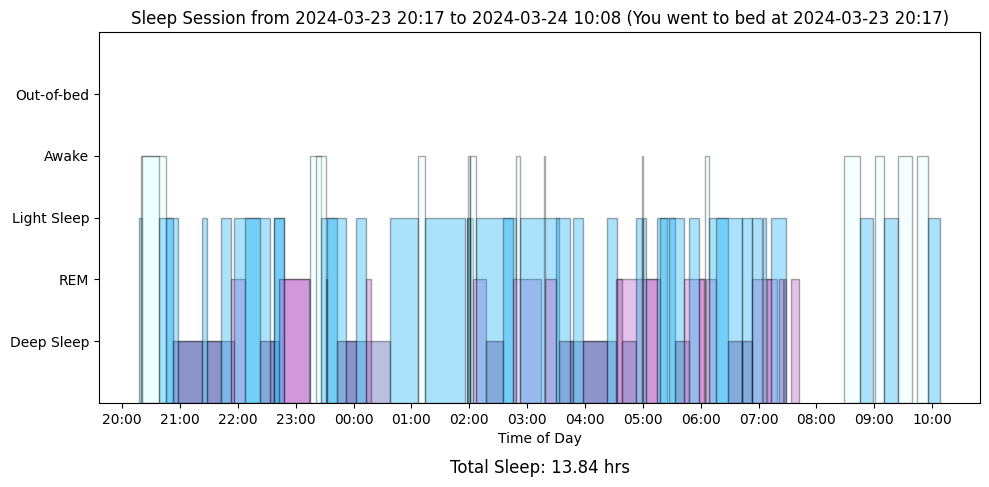

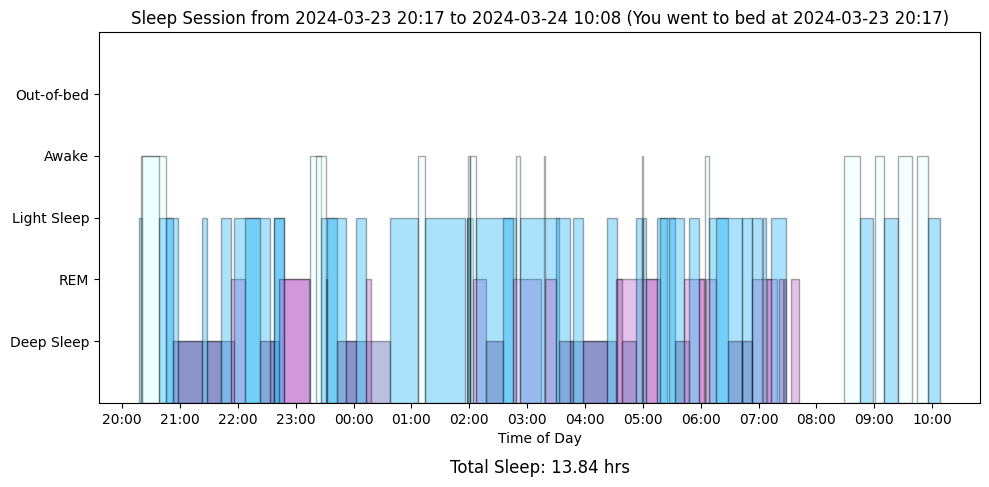

In [22]:

# 日付選択ウィジェット
date_picker = widgets.DatePicker(
    description='Select Date',
    disabled=False
)

# 前日と翌日に移動するボタンの作成
button_prev = widgets.Button(description="Previous Day")
button_next = widgets.Button(description="Next Day")

# ボタンのクリックイベントハンドラ
def on_prev_clicked(b):
    new_date = date_picker.value - pd.Timedelta(days=1)
    date_picker.value = new_date

def on_next_clicked(b):
    new_date = date_picker.value + pd.Timedelta(days=1)
    date_picker.value = new_date

button_prev.on_click(on_prev_clicked)
button_next.on_click(on_next_clicked)

# ボタンを表示
display(widgets.HBox([button_prev, button_next]))
display(date_picker)

# グラフ描画関数
def plot_sleep_data(date, data):
    date = pd.to_datetime(date).date()
    identified_sessions = identify_improved_sleep_sessions(data)
    session_data = None
    for start, end in identified_sessions:
        if start.date() <= date <= end.date():
            session_data = data[(data['start_time'] >= start) & (data['end_time'] <= end)]
            break
    
    if session_data is not None:

        data_sources = session_data['data_source'].unique()
        source_count = len(data_sources)
        alpha_value = 1 / source_count if source_count > 0 else 1  # データソースがない場合は透明度を1とする
        
        fig, ax = plt.subplots(figsize=(10, 5))
        stage_height = {
            3: 5,  # Out-of-bed
            1: 4,  # Awake
            4: 3,  # Light sleep
            6: 2,  # REM
            5: 1   # Deep sleep
        }
        stage_colors = {
            1: '#e0ffff',  # Awake
            3: '#ff5252',  # Out-of-bed
            4: '#03a9f4',  # Light sleep
            5: '#303f9f',  # Deep sleep
            6: '#ab47bc'   # REM
        }
        for index, row in session_data.iterrows():
            start_pos = mdates.date2num(row['start_time'])
            duration = mdates.date2num(row['end_time']) - start_pos
            ax.bar(
                x=start_pos,
                height=stage_height[row['sleep_state']],
                width=duration,
                color=stage_colors.get(row['sleep_state'], '#FFFFFF'),
                edgecolor='black',
                align='edge',
                alpha=alpha_value
            )
        ax.xaxis_date(tz=pytz.timezone('Asia/Tokyo'))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('Asia/Tokyo')))
        ax.set_ylim(0, 6)
        ax.set_yticks([1, 2, 3, 4, 5])
        ax.set_yticklabels(['Deep Sleep', 'REM', 'Light Sleep', 'Awake', 'Out-of-bed'])
        ax.set_xlabel('Time of Day')
        set_plot_title(ax, session_data)
        add_caption(ax, session_data)
        plt.tight_layout()
        plt.show()
        return session_data
    else:
        print("No sleep data available for this date.")

# 日付変更時のイベントハンドラ
def on_date_change(change):
    if change['new'] is not None:
        plot_sleep_data(change['new'], sleep_data)

date_picker.observe(on_date_change, names='value')